<a href="https://colab.research.google.com/github/diarrabell/fashion-recs/blob/main/fashion_recs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an exploratory notebook that was used to train the ResNet 50 model.

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
import urllib.request
import zipfile
import time
import copy

import PIL.Image


# **Image Classification**

## Get data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/data

/content/drive/MyDrive/data


In [ ]:
#! pip install -Uq kaggle

In [ ]:
#from google.colab import files
#files.upload()

In [ ]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#! kaggle datasets download paramaggarwal/fashion-product-images-small

In [ ]:
#! unzip fashion-product-images-small.zip

## Set up dataloaders

In [ ]:
class Dataloader:
    def __init__(self, dir, batch_size) -> None:
        self.dir = dir
        self.batch_size = batch_size
        self.data_transforms = {
            'train': transforms.Compose([
                transforms.Resize((256,256)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize((256,256)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),          
        }

        # Create datasets for training and validation sets
        self.train_dataset = datasets.ImageFolder(os.path.join(self.dir, 'train'), transform = self.data_transforms['train'])
        self.val_dataset = datasets.ImageFolder(os.path.join(self.dir, 'val'), transform=self.data_transforms['val'])

        # Create dataloaders for training and validation sets
        self.train_loader = torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)
        self.val_loader = torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)

        # Set up dict for dataloaders
        self.dataloaders = {'train': self.train_loader, 'val': self.val_loader}
        self.dataset_sizes = {'train': len(self.train_dataset), 'val': len(self.val_dataset)}
        self.class_names = self.train_dataset.classes
        print("Classes: {0}".format(self.class_names))

        print('sizes: ', self.dataset_sizes['train'], self.dataset_sizes['val'])
        print('imgs: ', self.train_loader.dataset.imgs)
        print('here: ', self.train_loader)

        #set random seeds for reproducibility
        torch.manual_seed(0)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(0)
    
    def plot_images(self):
        images, labels = next(iter(self.train_loader))
        print(type(images))
        print(type(labels))
        images = images.numpy()
        fig = plt.figure(figsize=(10, 6))
        for idx in np.arange(self.batch_size):
            ax = fig.add_subplot(2, self.batch_size//2, idx+1, xticks=[], yticks=[])
            image = images[idx]
            image = image.transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std * image + mean
            image = np.clip(image, 0, 1)
            ax.imshow(image)
            ax.set_title("{}".format(self.class_names[labels[idx]]))
        plt.show()



In [ ]:
 #create dataloader using Dataloader class, takes in data directory and batch size
data_dir = '/content/drive/MyDrive/data/data/'
batch_size = 4
print("Creating Dataloaders...")
dl = Dataloader(data_dir, batch_size)

Creating Dataloaders...
Classes: ['70s', '80s', '90s', 'boho', 'cottagecore', 'goth', 'kawaii', 'y2k']
sizes:  740 173
imgs:  [('/content/drive/MyDrive/data/data/train/70s/1447445509-hbz-70s-fashion-1970-catherine-deneuve-gettyimages-1664772652.jpg', 0), ('/content/drive/MyDrive/data/data/train/70s/1970s-Fashion-Model-Yellow-Flared-Pants.jpg', 0), ('/content/drive/MyDrive/data/data/train/70s/1970s-Fashion-Women-Sunglasses.jpg', 0), ('/content/drive/MyDrive/data/data/train/70s/1970s-Leather-Jacket-Inspiration-Women.jpg', 0), ('/content/drive/MyDrive/data/data/train/70s/1970s-Platforms.jpg', 0), ('/content/drive/MyDrive/data/data/train/70s/1970s-fashion-trends-sinclair01.jpg', 0), ('/content/drive/MyDrive/data/data/train/70s/1970s-fashion-trends-sinclair03.jpg', 0), ('/content/drive/MyDrive/data/data/train/70s/1970s-fashion-trends-sinclair04.jpg', 0), ('/content/drive/MyDrive/data/data/train/70s/1970s-fashion-trends-sinclair05.jpg', 0), ('/content/drive/MyDrive/data/data/train/70s/1b8a1a

------------------------
Plotting batch of images...
<class 'torch.Tensor'>
<class 'torch.Tensor'>


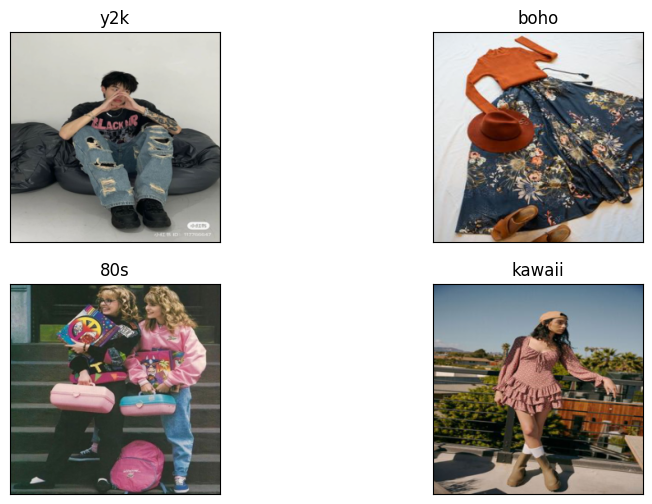

In [ ]:
# plot the images in the training set
print("------------------------")
print("Plotting batch of images...")
dl.plot_images() 

Train ResNet50 Model

In [ ]:
class ResNet:
    ''' initialize resnet50 model '''
    def __init__(self, batch_size, dataset_sizes) -> None: 
      self.dataset_sizes = dataset_sizes
      self.batch_size = batch_size
      # instantiate pre-trained resnet
      self.model = torchvision.models.resnet50(pretrained=True)
      # shut off autograd for all layers to freeze model so layer weights are not trained
      for param in self.model.parameters():
          param.requires_grad = False       
      # get number of inputs to final linear layer
      self.num_ftrs = self.model.fc.in_features
      # replace final linear layer with new linear layer with 8 outputs
      self.model.fc = nn.Linear(self.num_ftrs, 8)
      # cost function: cross entropy loss
      self.criterion = nn.CrossEntropyLoss()
      # optimizer: SGD
      self.optimizer = optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)
      # learning rate scheduler
      self.lr_scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=5, gamma=0.1)
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    ''' train model '''
    def train_model(self, dataloaders, num_epochs): #train model
        writer = SummaryWriter()
        # self.dataloaders = dataloaders
        model = self.model.to(self.device)
        since = time.time()

        best_model_wts = copy.deepcopy(model.state_dict)
        best_acc = 0.0

        trainingEpoch_loss = []
        validationEpoch_loss = []
        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train': #set model to training mode
                    model.train()
                else:
                    model.eval() # set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # get input images and labels, and send to GPU if available
                print('phase: ', phase)
                #print('imgs: ', dataloaders[phase].dataset.imgs)
                # for i in next(iter(self.dataloaders[phase])):
                #   print(i)
        

                for inputs, labels in dataloaders[phase]:
      
                  # print(len(inputs))
                  # print(len(labels))
                  inputs = inputs.to(self.device)
                  labels = labels.to(self.device)

                  #zero the weight gradients
                  self.optimizer.zero_grad()

                  #forward pass to get outputs and calculate loss
                  #track gradient only for training data
                  with torch.set_grad_enabled(phase == 'train'):
                      outputs = model(inputs)
                      _, preds = torch.max(outputs, 1)
                      loss = self.criterion(outputs, labels)

                      #backpropagation to get the gradients with respect to each weight, only if in train
                      if phase == 'train':
                          loss.backward()
                          # update the weights
                          self.optimizer.step()

                  # convert loss into a scalar and add it to running loss
                  running_loss += loss.item() * inputs.size(0)

                  #track number of correct predictions
                  running_corrects += torch.sum(preds == labels.data)

                # step along learning rate scheduler when in train
                if phase == 'train':
                    self.lr_scheduler.step()
                
                # calculate and display average loss and accuracy for the epoch
                epoch_loss = running_loss / self.dataset_sizes[phase]
                epoch_acc = running_corrects.double() / self.dataset_sizes[phase]
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                if phase == 'train':
                  writer.add_scalar("Loss/train", epoch_loss)
                  writer.add_scalar("Accuracy/train", epoch_acc)
                  trainingEpoch_loss.append(epoch_loss)

                if phase == 'val':
                  writer.add_scalar("Loss/val", epoch_loss)
                  writer.add_scalar("Accuracy/val", epoch_acc)
                  validationEpoch_loss.append(epoch_loss)

                # if model performs better on val set, save weights as the best model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                print()
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:3f}'.format(best_acc))

        from matplotlib import pyplot as plt
        plt.plot(trainingEpoch_loss, label='train_loss')
        plt.plot(validationEpoch_loss,label='val_loss')
        plt.legend()
        plt.show



        #load weights from best model
        model.load_state_dict(best_model_wts)
        self.final_model = model

    def visualize_results(self, val_loader, class_names):
        model = self.final_model.to(self.device)
        with torch.no_grad():
            model.eval()
            # get a batch of validation images
            images, labels = next(iter(val_loader))
            images, labels = images.to(self.device), labels.to(self.device)
            # get predictions
            _, preds = torch.max(model(images), 1)
            preds = np.squeeze(preds.cpu().numpy())
            images = images.cpu().numpy()
    
    def savemodel(self):
      filename = 'model.pt'
      torch.save(self.final_model, filename)
    

Train model

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 351MB/s]


------------------------
Training model...
Epoch 0/23
----------
phase:  train
train Loss: 1.9385 Acc: 0.2676

phase:  val
val Loss: 1.3204 Acc: 0.5607

Epoch 1/23
----------
phase:  train
train Loss: 1.5793 Acc: 0.4243

phase:  val
val Loss: 1.2096 Acc: 0.6358

Epoch 2/23
----------
phase:  train
train Loss: 1.4352 Acc: 0.4757

phase:  val
val Loss: 1.0567 Acc: 0.6416

Epoch 3/23
----------
phase:  train
train Loss: 1.2636 Acc: 0.5419

phase:  val
val Loss: 0.9583 Acc: 0.7052

Epoch 4/23
----------
phase:  train
train Loss: 1.2799 Acc: 0.5405

phase:  val
val Loss: 0.9467 Acc: 0.6474

Epoch 5/23
----------
phase:  train
train Loss: 1.0187 Acc: 0.6689

phase:  val
val Loss: 0.9451 Acc: 0.6879

Epoch 6/23
----------
phase:  train
train Loss: 0.9961 Acc: 0.6662

phase:  val
val Loss: 0.9738 Acc: 0.6821

Epoch 7/23
----------
phase:  train
train Loss: 0.9920 Acc: 0.6878

phase:  val
val Loss: 0.9626 Acc: 0.6763

Epoch 8/23
----------
phase:  train
train Loss: 1.0451 Acc: 0.6473

phase:  v

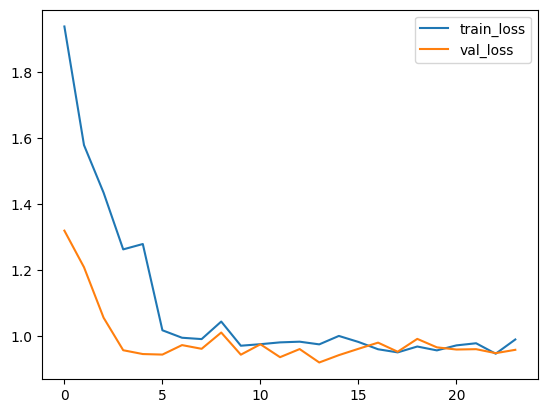

In [ ]:
# instantiate pre-trained resnet 50
resnet = ResNet(batch_size, dl.dataset_sizes)

# train model
num_epochs = 24
print("------------------------")
print("Training model...")
resnet.train_model(dl.dataloaders, num_epochs)

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir runs

In [ ]:
#save model
resnet.savemodel()

In [ ]:
def test_model(model, test_loader, device):
    model = model.to(device)
    #turn autograd off
    with torch.no_grad():
        #set the model to evaluation mode
        model.eval()
        #set up lists to store true and predicted values
        y_true = []
        test_preds = []
        test_probs = []
        #calculate the predictions on the test set and add to list
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            #feed inputs through model to get raw scores
            logits = model.forward(inputs)
            #convert raw scores to probabilities
            probs = F.softmax(logits, dim=1)
            #get discrete predictions using argmax
            preds = np.argmax(probs.numpy(), axis=1)
            #add predictions and actuals to lists
            test_preds.extend(preds)
            test_probs.extend(probs)
            y_true.extend(labels)
    
    return test_preds, test_probs



In [ ]:
# Script that evalutates test data using trained model

class TestData:
  def __init__(self, model, dataloader, device, class_names) -> None:
    self.model = model
    self.dataloader = dataloader
    self.device = device
    self.class_names = class_names
  
  def test_model(self):
    self.model = self.model.to(self.device)
    #turn autograd off
    with torch.no_grad():
      #set the model to evaluation mode
      self.model.eval()
      #set up lists to store true and predicted values
      y_true = []
      test_preds = []
      test_probs = []
      #calculate the predictions on the test set and add to list
      for data in self.dataloader:
        inputs, labels = data[0].to(self.device), data[1].to(self.device)
        #feed inputs through model to get raw scores
        logits = self.model.forward(inputs)
        #convert raw scores to probabilities
        probs = F.softmax(logits, dim=1)
        #get discrete predictions using argmax
        preds = np.argmax(probs.detach().cpu().numpy(), axis=1)
        #add predictions and actuals to lists
        test_preds.extend(preds)
        test_probs.extend(probs)
        y_true.extend(labels.cpu())

    #calculate accuracy
    test_preds = np.array(test_preds)
    y_true = np.array(y_true)
    test_acc = np.sum(test_preds == y_true)/y_true.shape[0]


    self.test_preds = test_preds
    return self.test_preds

In [ ]:
def visualize_results(model, dataloader, device):
  model = model.to(device)
  with torch.no_grad():
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    #get predictions
    _, preds = torch.max(model(images), 1)
    preds = np.squeeze(preds.cpu().numpy())
    images = images.cpu().numpy()

  #plot the images with predictions
  fig = plt.figure(figsize=(15, 10))
  for idx in np.arange(len(preds)):
    ax = fig.add_subplot(2, len(preds)//2, idx+1, xticks=[], yticks=[])
    image = images[idx]
    image = image.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.set_title("{}".format(dl.class_names[preds[idx]], color = "blue"))

In [ ]:
! rm -rf `find -type d -name .ipynb_checkpoints`

[6 6 6 6 3 4 4 5 4 4]


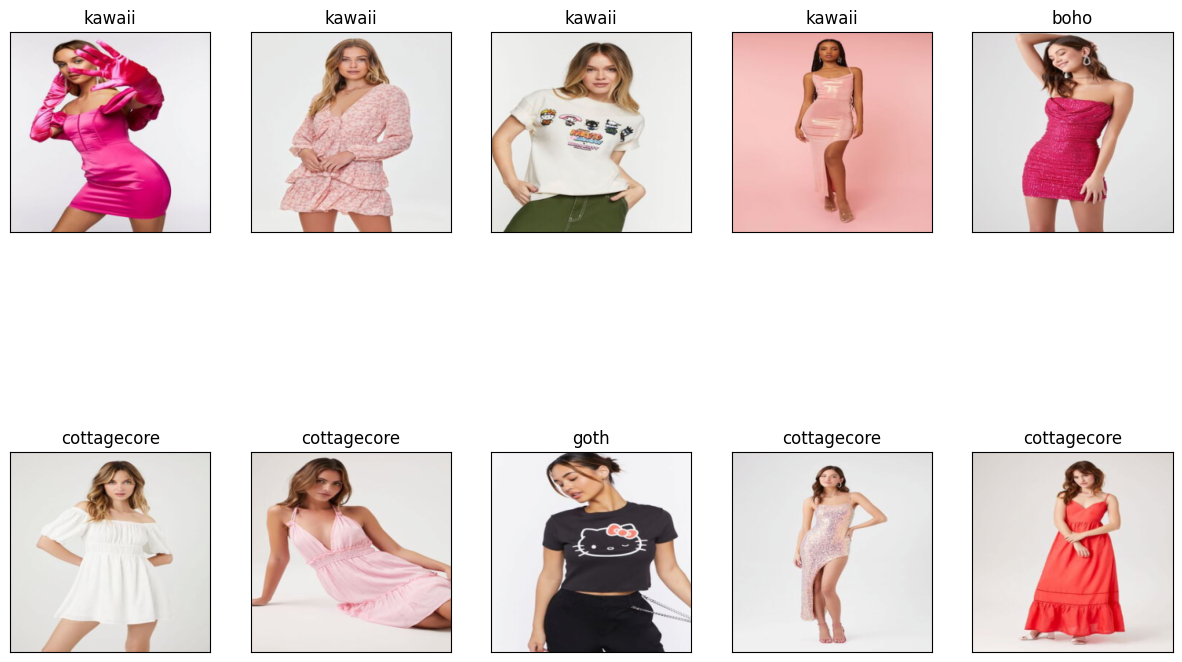

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.load('/content/drive/MyDrive/data/model.pt', map_location = torch.device(device))
model.eval()
test_transform = transforms.Compose([
      transforms.Resize((256, 256)),   
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])
test_dataset = datasets.ImageFolder("/content/drive/MyDrive/data/test-data/", transform=test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=10)
classes = dl.class_names
test = TestData(model, test_dataloader, device, classes)
predictions = test.test_model()
# idx = int(prediction[0])
# prediction = "prediction class: " + classes[idx]
print(predictions)

visualize_results(model, test_dataloader, device)

In [ ]:
#convert to df


predictions = list(predictions)
top_predictions = [x for x in predictions if predictions.count(x) > 1]
top_predictions = list(set(top_predictions))

top_predictions = [classes[x] for x in top_predictions]

print(top_predictions)

data = ' '.join(top_predictions)
print(data)

df = pd.DataFrame({'img_name': 'test', 'aesthetics': data}, index=[0])
df

